<a href="https://www.kaggle.com/code/minhhongon/vlsp-nlp-eng-to-vie?scriptVersionId=287771415" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q transformers datasets evaluate sacrebleu accelerate
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -U "protobuf==3.20.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [3]:
import os
from datasets import Dataset, DatasetDict

base_path = "/kaggle/input/vlsp-dataset"
train_en_path = os.path.join(base_path, "train.en.txt")
train_vi_path = os.path.join(base_path, "train.vi.txt")
test_en_path = os.path.join(base_path, "public_test.en.txt")
test_vi_path = os.path.join(base_path, "public_test.vi.txt")

In [4]:
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()
    return lines

In [5]:
print("Đang đọc dữ liệu...")
train_en = read_text_file(train_en_path)
train_vi = read_text_file(train_vi_path)
val_en = read_text_file(test_en_path)
val_vi = read_text_file(test_vi_path)

print(f"Số câu Train En: {len(train_en)}")
print(f"Số câu Train Vi: {len(train_vi)}")
assert len(train_en) == len(train_vi), "Lỗi: Số dòng file Anh và Việt không khớp nhau!"

Đang đọc dữ liệu...
Số câu Train En: 500000
Số câu Train Vi: 500000


In [6]:
train_dataset = Dataset.from_dict({"en": train_en, "vi": train_vi})
val_dataset = Dataset.from_dict({"en": val_en, "vi": val_vi})

raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
})

print("Load dữ liệu thành công:")
print(raw_datasets)

Load dữ liệu thành công:
DatasetDict({
    train: Dataset({
        features: ['en', 'vi'],
        num_rows: 500000
    })
    validation: Dataset({
        features: ['en', 'vi'],
        num_rows: 3000
    })
})


In [7]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    inputs = examples["en"]
    targets = examples["vi"]
    
    tokenizer.src_lang = "eng_Latn"
    tokenizer.tgt_lang = "vie_Latn"

    model_inputs = tokenizer(
        inputs,                      
        text_target=targets,          
        max_length=128,
        truncation=True
    )
    
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [8]:
import evaluate
import numpy as np
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

2025-12-22 08:58:54.991381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766393935.151160      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766393935.195537      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

metric = evaluate.load("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
        
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [10]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()
print("Đã dọn dẹp bộ nhớ GPU!")

Đã dọn dẹp bộ nhớ GPU!


In [11]:
import os
import torch
import gc
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from peft import get_peft_model, LoraConfig, TaskType

In [12]:
torch.cuda.empty_cache()
gc.collect()

17

In [13]:
base_path = "/kaggle/input/vlsp-dataset"
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read().splitlines()

In [14]:
print("Đang load dữ liệu...")
train_dataset = Dataset.from_dict({"en": read_text_file(os.path.join(base_path, "train.en.txt")), "vi": read_text_file(os.path.join(base_path, "train.vi.txt"))})
val_data_full = Dataset.from_dict({"en": read_text_file(os.path.join(base_path, "public_test.en.txt")), "vi": read_text_file(os.path.join(base_path, "public_test.vi.txt"))})
val_dataset = val_data_full.select(range(500)) 

raw_datasets = DatasetDict({'train': train_dataset, 'validation': val_dataset})

Đang load dữ liệu...


In [15]:
model_checkpoint = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, src_lang="eng_Latn", tgt_lang="vie_Latn")

In [16]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["en"], text_target=examples["vi"], max_length=128, truncation=True)
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [17]:
print("Đang load model...")
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Đang load model...


In [18]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, 
    inference_mode=False, 
    r=16,               
    lora_alpha=32, 
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 2,359,296 || all params: 617,433,088 || trainable%: 0.3821


In [19]:
args = Seq2SeqTrainingArguments(
    output_dir="medical_nllb_final",
    eval_strategy="steps",
    eval_steps=1000,                
    save_strategy="steps",
    save_steps=1000,                
    learning_rate=3e-4,
    
    max_steps=4000,                 
    
    per_device_train_batch_size=4,   
    gradient_accumulation_steps=8,  
    gradient_checkpointing=False,    
    
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,             
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

In [20]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipykernel_20/3298469325.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [21]:
print("Bắt đầu train ")
trainer.train()

trainer.model.save_pretrained("./final_adapter")
tokenizer.save_pretrained("./final_adapter")
trainer.save_state()

Bắt đầu train 


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,1.847100,1.597641
2000,1.758900,1.519212
3000,1.716000,1.481553
4000,1.693700,1.469991


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Saved history.
Saved plot!'.


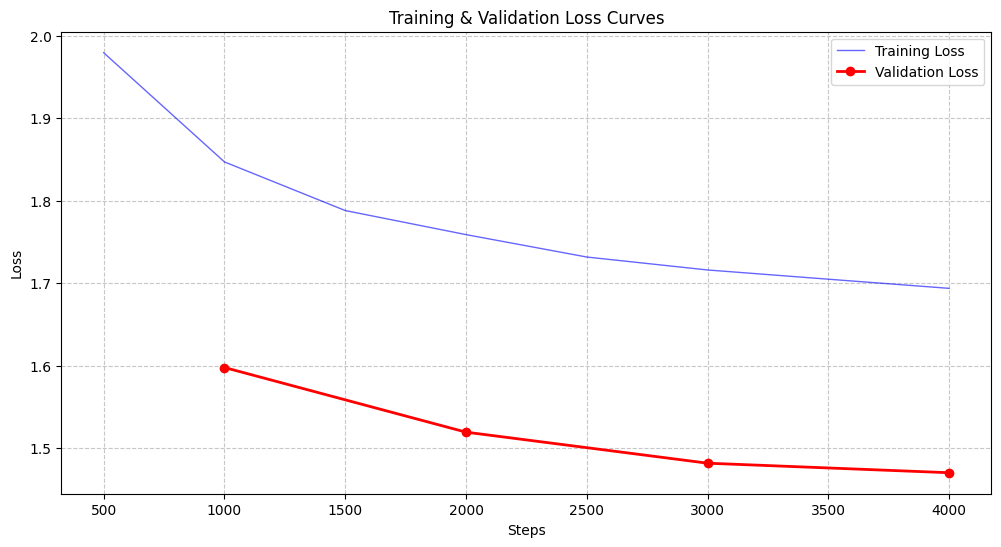

In [22]:
import matplotlib.pyplot as plt
import json
import pandas as pd

history = trainer.state.log_history

with open("training_log.json", "w", encoding='utf-8') as f:
    json.dump(history, f)
print("Saved history.")

train_data = []
eval_data = []

for log in history:
    if "loss" in log and "step" in log:
        train_data.append({"step": log["step"], "loss": log["loss"]})
    if "eval_loss" in log and "step" in log:
        eval_data.append({"step": log["step"], "loss": log["eval_loss"]})

df_train = pd.DataFrame(train_data)
df_eval = pd.DataFrame(eval_data)

plt.figure(figsize=(12, 6))

if not df_train.empty:
    plt.plot(df_train["step"], df_train["loss"], label='Training Loss', 
             color='blue', alpha=0.6, linewidth=1)

if not df_eval.empty:
    plt.plot(df_eval["step"], df_eval["loss"], label='Validation Loss', 
             color='red', marker='o', linewidth=2)

plt.title('Training & Validation Loss Curves')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig("loss_plot_eng_to_vie.png")
print("Saved plot!'.")

plt.show()

In [23]:
import os

os.makedirs("./export_model", exist_ok=True)

!cp -r ./final_adapter/* ./export_model/

!zip -r Medical_Translation_BLEU40.zip ./export_model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: export_model/ (stored 0%)
  adding: export_model/README.md (deflated 66%)
  adding: export_model/special_tokens_map.json (deflated 79%)
  adding: export_model/adapter_config.json (deflated 55%)
  adding: export_model/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 82%)
  adding: export_model/adapter_model.safetensors (deflated 7%)
  adding: export_model/tokenizer_config.json (deflated 94%)
  adding: export_model/sentencepiece.bpe.model (deflated 51%)
